In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Quadratic Equation (Parabola)
def f(x):
  return 3*x**2 -4*x + 5

In [4]:
f(3.0)

20.0

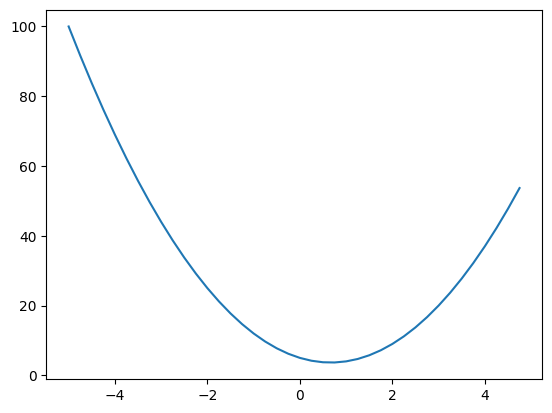

In [5]:
# Creating a Range of Values from -5 to 5 with steps of 0.25
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [6]:
# Figuring out what is the Derivative of this at every single point x
# Basically applying Limits
h = 0.0001
# Derivative is zero at 2/3
x = 2/3
print(f(x))
# f(x+h) will be slightly greater as we can say by looking at the parabola above
print(f(x+h))
# The expression below gives the derivative of the f(x) which is 6x-4
(f(x+h) - f(x))/h

3.666666666666667
3.666666696666667


0.0002999999981767587

In [7]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
d

4.0

In [8]:
# Derivative of  Function with Multiple Inputs
h = 0.00001
# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# Apply it for a,b,c (Basically applying derivative w..r.t da,db,dc)
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h) # The Slope ends upbeing negative as we cna see value of d2 is lower when h is added to a

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [130]:
# Data Structures for maintaining huge Mathematical Expressions required for building neural networks
class value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data =  data
    self.prev = set(_children)
    self.grad = 0.0
    self.label = label
    self._op = _op
    self._backward = lambda: None
  # Helps in printing out a nicer looking expression
  def __repr__(self):
    return f"value(data={self.data})"
# These special underscore methods are used to create Operators
# Whenever we add or multiply the children come into play
  def __add__(self, other):
    other = other if isinstance(other, value) else value(other)
    # The step above is done to make sure that if the other instance is not a value it gets converted into one
    out = value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out


  def __mul__(self, other):
    other = other if isinstance(other, value) else value(other)
    out = value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def _rmul__(self, other): #other * self
    return self * other

  def __truediv__(self, other): #self/othe
    return self * other**-1

  def __rtruediv__(self, other): # other / self
        return other * self**-1

  def __neg__(self):
    return self * -1

  def __radd__(self, other): # other + self
        return self + other

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out



  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = value(2.0, label='a')
b = value(-3.0, label='b')
c = value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = value(-2.0, label='f')
l = d * f; l.label = 'l'
l
#a*b + c
# This is basically (a.__mul__(b)).__add__(c)

value(data=-8.0)

In [41]:
a = value (2.0, label='a')
b = value(4.0, label='b')


value(data=0.5)

In [10]:
d.prev

{value(data=-6.0), value(data=10.0)}

In [11]:
d._op

'+'

In [12]:
# Code for Visualising these expression
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

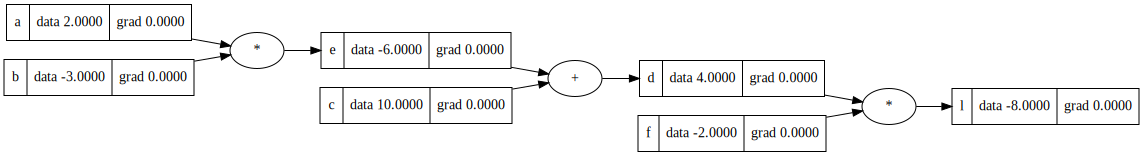

In [13]:
draw_dot(l)

Backpropagation will start at 'l' and calculate the derivative of all the values w.r.t. 'l'. These nodes represent weights in a neural netowrk.

L = d*f

---


dL/dd = f

---


f(x+h) - f(x) / h

---


(d+h)*f - d*f / h

---


(d*f + h*f - d*f) / h

---


(h*f)/h

---


f

In [14]:
# Nudging our inputs trying to make L go up (Decrease Loss)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
l = d * f
print(l.data)

-8.0


In [15]:
def lol():

  h = 0.0001

  a = value(2.0, label='a')
  b = value(-3.0, label='b')
  c = value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = value(-2.0, label='f')
  l = d * f; l.label = 'l'
  l1 = l.data

  a = value(2.0, label='a')
  b = value(-3.0, label='b')
  c = value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = value(-2.0, label='f')
  l = d * f; l.label = 'l'
  l2 = l.data

  print('slope', (l2-l1)/h)

lol()

slope 0.0


In [16]:
'''
L = d*f
dL/dd = f
f(x+h) - f(x) / h
(d+h)*f - d*f / h
(d*f + h*f - d*f) / h
(h*f)/h
= f
This logic will also apply for a,b

dl/da = dl/de * de/da
       = -2.0 * b
       = -2.0 * -3.0
       = 6.0
dl/db = dl/de * de/db
       = -2.0 * a
       = -2.0 * 2.0
       = -4.0

d = e + c
dd/dc = 1
dd/de = 1

l = (c+e)*f

dl / dc -> To calculate this we use the chain rule from Calculus  dx/dz = dx/dy * dy/dz

dl/ dc = (dl/dd) * (dd/dc)
       = dl/dd * 1
       = -2.0 * 1
       = -2.0

Similarly , dl/de = (dl/dd) * (dd/de) = -2.0 * 1 = -2.0

'''

'\nL = d*f\ndL/dd = f\nf(x+h) - f(x) / h\n(d+h)*f - d*f / h\n(d*f + h*f - d*f) / h\n(h*f)/h\n= f\nThis logic will also apply for a,b\n\ndl/da = dl/de * de/da\n       = -2.0 * b\n       = -2.0 * -3.0\n       = 6.0\ndl/db = dl/de * de/db\n       = -2.0 * a\n       = -2.0 * 2.0\n       = -4.0\n\nd = e + c\ndd/dc = 1\ndd/de = 1\n\nl = (c+e)*f\n\ndl / dc -> To calculate this we use the chain rule from Calculus  dx/dz = dx/dy * dy/dz\n\ndl/ dc = (dl/dd) * (dd/dc)\n       = dl/dd * 1\n       = -2.0 * 1\n       = -2.0\n\nSimilarly , dl/de = (dl/dd) * (dd/de) = -2.0 * 1 = -2.0\n\n'

In [17]:
# Essentially this is what backpropagation is. Manual Backpropagation. We go back 1 by 1 and go thorugh each node applying chain rule recursively as we go along.
l.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
b.grad = -4.0
a.grad = 6

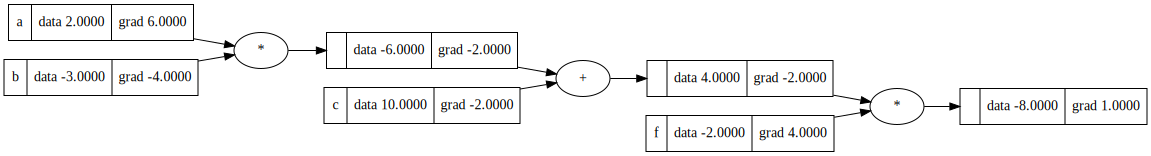

In [18]:
draw_dot(l)

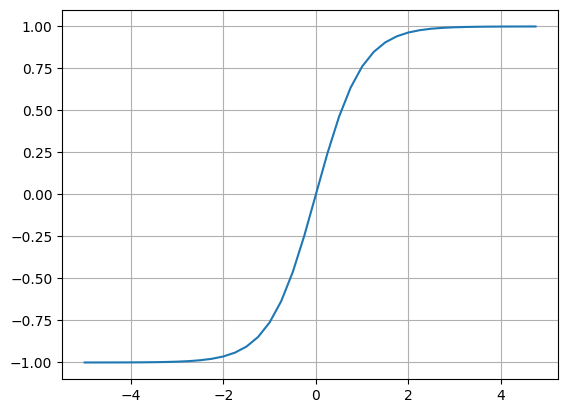

In [19]:
# tanh funtion
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5,5,0.25))); plt.grid();

In [72]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weihts w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

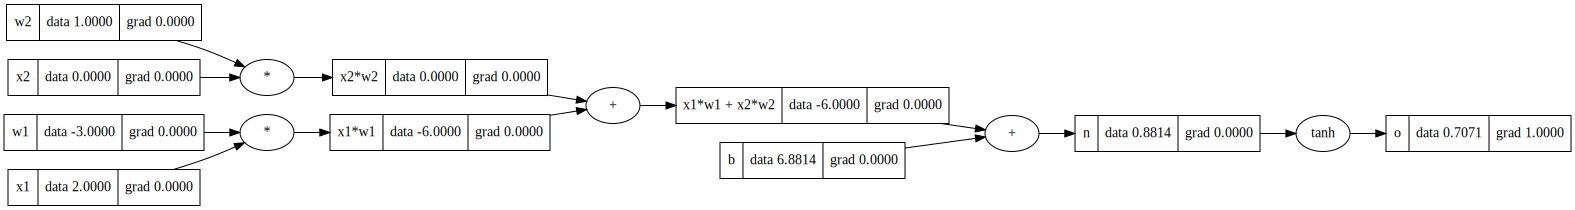

In [73]:
draw_dot(o)

In [27]:
'''
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x2._backward()
x1._backward()
w2._backward()
w1._backward()
'''
# Created a function for this

In [24]:
# Doing Backpropagation and filling in all the gradients
'''
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data *x2w2.grad
x1.grad = w1.data *x1w1.grad
w2.grad = x2.data *x2w2.grad
w1.grad = x1.data *x1w1.grad
'''

'\no.grad = 1.0\nn.grad = 0.5\nb.grad = 0.5\nx1w1x2w2.grad = 0.5\nx1w1.grad = 0.5\nx2w2.grad = 0.5\nx2.grad = w2.data *x2w2.grad\nx1.grad = w1.data *x1w1.grad\nw2.grad = x2.data *x2w2.grad\nw1.grad = x1.data *x1w1.grad\n'

In [25]:
# o = tanh(n)
# do/dn = 1 - tanh**2(n)
# do/dn = 1 - o**2
# The derivative of w2 is 0 therefore it has no impact on the final output.


Topological Sort

In [29]:
    '''
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
      build_topo(self)
      '''
      # This is topological sort the function were using for assigning the gradient backwards


We changed our functions to make sure the gradient is added instead of it being changed everytime we call the same variable twice.

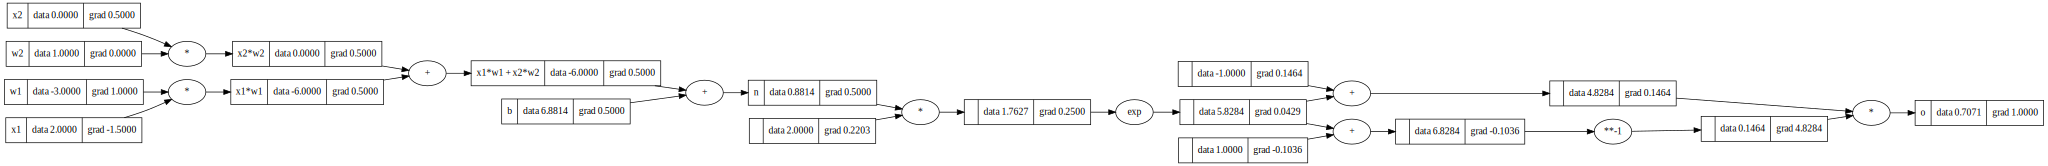

In [94]:
# Perfroming backprogation and doing the same task but breaking up tanh

# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weihts w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# _____
e = (n*2).exp()
o = (e - 1) / (e + 1)
# _____
o.label = 'o'
o.grad = 1.0
o.backward()
draw_dot(o)

# Implementing the same thing but in PyTorch

In [76]:
import torch

x1 = torch.tensor([2.0]).double()         ; x1.requires_grad=True
x2 = torch.tensor([0.0]).double()         ; x2.requires_grad=True
w1 = torch.tensor([-3.0]).double()        ; w1.requires_grad=True
w2 = torch.tensor([1.0]).double()         ; w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double()  ; b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
# .item is used to remove the tensor
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [81]:
print(torch.Tensor([2.0]).dtype)
torch.Tensor([2.0]).double().dtype
# Python by default uses double precision for its floating point numbers thats why we are adding in the .double()
# Since these are all leaf nodes by default PyTorch assumes they don't require gradient so we change that

torch.float32


torch.float64

In [82]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [84]:
o.item()
o.data.item()

0.7071066904050358

In [88]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [90]:
w2.item()


1.0

In [137]:
import random
class Neuron:

    def __init__(self, nin, nonlin=True): # nin is number of inputs to the neuron
        self.w = [value(random.uniform(-1,1)) for _ in range(nin)] # a random weight from -1 to 1 for each input
        self.b = value(random.uniform(-1,1)) # a random bias that controls the trigger happiness of the neuron
        self.nonlin = nonlin
    def __call__(self, x):
      # w * x + b here w * x is a dot product
        #zip = zip(self.w, x) # zip combines elements from two or more iterables into tuples. Here w's will be paired with x's
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) # activation
        return act.tanh() if self.nonlin else act
    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer:

    def __init__(self, nin, nout, **kwargs): # Layer is a list of neurons # The numbers of neurons in your layer is nout (Number of Outputs)
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP():

    def __init__(self, nin, nouts): # Here instead of nout which is the number of neurons in a single we take nouts which is a list of nout which defines the size of all the layers in out
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [118]:
x = [2.0, 3.0] # These are the input neurons
l = Layer(2, 3) # Three neurons in the layer
l(x)

[value(data=-0.8928864274243902),
 value(data=-0.882499842020337),
 value(data=0.7827380593704125)]

In [220]:
x = [2.0, 3.0, -1] # These are the input neurons
n = MLP(3, [4,4,1]) # These are the output neurons # 4 neurons in the second and third layer and finally 1 output neuron
n(x)

value(data=0.8154027548434118)

In [ ]:
draw_dot(n(x))

In [221]:
# Data Definition
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[value(data=0.8154027548434118),
 value(data=0.7488936784994711),
 value(data=0.8770516741433595),
 value(data=0.850872587458842)]

In [144]:
len(n.parameters())

41

In [214]:
n.layers[0].neurons[0].w[0].grad # Prints Gradient for this weight
n.layers[0].neurons[0].w[0].data # Prints Data

-2.031171243544568

In [ ]:
draw_dot(loss)

In [140]:
# Loss Calculation
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # ygt is actual output and yout is desired output
loss

value(data=5.0127991374619985)

In [212]:
# Forward Pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # ygt is actual output and yout is desired output
loss

value(data=0.02892417029403911)

In [210]:
# Backwards Pass
loss.backward()

In [211]:
# Updating the Values (Gradient Descent)
for p in n.parameters():
  p.data += p.grad * -0.01 # 0.01 is the learning rate

In [265]:
# All together in a loop
for k in range (500):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # Backwards Pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += p.grad * -0.05

  #print(k, loss.data)

In [268]:
ypred

[value(data=0.9950456718523274),
 value(data=-0.9955049464683251),
 value(data=-0.9914642914275493),
 value(data=0.9933507190615605)]